### Text Summarization

We already know the importance of text summarization and how helpful
it can be when dealing with big text documents, say a big Wikipedia page.

There are two categories for text summarization as a NLP task.

#### Extractive Text Summarization

Select most relevant phrases of the document and concatenate them to
form a summary (like “copy-and-paste”). A feature-based approach to this
would evaluate each sentence based on some features and rank them
accordingly. Then it returns sentences with the highest feature value.

#### Abstractive Text Summarization

A summary that consists of sentences generated by a model that keeps
the original intent of the text but uses different sentences. As we can
guess, Deep Learning models are the best models to generate these sentences.

We cover Extractive method here since we haven't covered Deep Learning
methods. `Long Short Term Memory` Networks are mostly used in the
deep networks.

Let's Summarize the McMaster Wikipedia page.

[https://en.wikipedia.org/wiki/McMaster_University](https://en.wikipedia.org/wiki/McMaster_University)

In [15]:
import bs4 as bs
import requests

raw_data = requests.get('https://en.wikipedia.org/wiki/McMaster_University')
raw_document = raw_data.text

processed_document = bs.BeautifulSoup(raw_document, 'lxml')

# For more details on CSS selectors visit this page
# https://www.w3schools.com/css/css_selectors.asp
paragraphs = processed_document.find_all('p')
paragraphs[2]

<p><b>McMaster University</b> (<b>McMaster</b> or <b>Mac</b>) is a <a href="/wiki/Public_university" title="Public university">public</a> <a href="/wiki/Research_university" title="Research university">research university</a> in <a href="/wiki/Hamilton,_Ontario" title="Hamilton, Ontario">Hamilton, Ontario</a>, Canada. The main McMaster campus is on 121 hectares (300 acres) of land near the residential neighbourhoods of <a class="mw-redirect" href="/wiki/Ainslie_Wood,_Ontario" title="Ainslie Wood, Ontario">Ainslie Wood</a> and <a class="mw-redirect" href="/wiki/Westdale,_Ontario" title="Westdale, Ontario">Westdale</a>, adjacent to the <a class="mw-redirect" href="/wiki/Royal_Botanical_Gardens,_Ontario" title="Royal Botanical Gardens, Ontario">Royal Botanical Gardens</a>.<sup class="reference" id="cite_ref-MACFF_7-0"><a href="#cite_note-MACFF-7">[6]</a></sup> It operates six <a href="/wiki/Faculty_(division)" title="Faculty (division)">academic faculties</a>: the <a href="/wiki/DeGroote_

Let's see the type of paragraph objects

In [16]:
print(type(paragraphs[2]))
print(paragraphs[2].__dir__())

<class 'bs4.element.Tag'>
['parser_class', 'name', 'namespace', 'prefix', 'preserve_whitespace_tags', 'known_xml', 'attrs', 'contents', 'parent', 'previous_element', 'next_element', 'next_sibling', 'previous_sibling', 'hidden', 'can_be_empty_element', '__module__', '__doc__', '__init__', 'parserClass', '__copy__', 'is_empty_element', 'isSelfClosing', 'string', '_all_strings', 'strings', 'stripped_strings', 'get_text', 'getText', 'text', 'decompose', 'clear', 'index', 'get', 'get_attribute_list', 'has_attr', '__hash__', '__getitem__', '__iter__', '__len__', '__contains__', '__bool__', '__setitem__', '__delitem__', '__call__', '__getattr__', '__eq__', '__ne__', '__repr__', '__unicode__', '__str__', 'encode', '_should_pretty_print', 'decode', 'prettify', 'decode_contents', 'encode_contents', 'renderContents', 'find', 'findChild', 'find_all', 'findAll', 'findChildren', 'children', 'descendants', 'select_one', 'select', 'childGenerator', 'recursiveChildGenerator', 'has_key', 'HTML_FORMATTER

So probably the `text` property would be helpful

In [17]:
paragraphs[2].text

'McMaster University (McMaster or Mac) is a public research university in Hamilton, Ontario, Canada. The main McMaster campus is on 121 hectares (300 acres) of land near the residential neighbourhoods of Ainslie Wood and Westdale, adjacent to the Royal Botanical Gardens.[6] It operates six academic faculties: the DeGroote School of Business, Engineering, Health Sciences, Humanities, Social Science, and Science. It is a member of the U15, a group of research-intensive universities in Canada.[7][8]\n'

Now that we have each paragraph, let's concat them together to
form the final textual data

In [18]:
document = ""
for p in paragraphs:
    document += p.text

# Let's print the first 500 characters!
document[:500]


'\n\nMcMaster University (McMaster or Mac) is a public research university in Hamilton, Ontario, Canada. The main McMaster campus is on 121 hectares (300 acres) of land near the residential neighbourhoods of Ainslie Wood and Westdale, adjacent to the Royal Botanical Gardens.[6] It operates six academic faculties: the DeGroote School of Business, Engineering, Health Sciences, Humanities, Social Science, and Science. It is a member of the U15, a group of research-intensive universities in Canada.[7]['

Wikipedia text includes lots of references, so let's remove them
to have a clean text.

In [19]:
import re

# Get rid of reference brackets
document = re.sub(r'\[[0-9]*\]', ' ', document)
# Get rid of extra white spaces
document = re.sub(r'\s+', ' ', document)
# Get rid of initial and final spaces
document = document.strip()

document[:500]

'McMaster University (McMaster or Mac) is a public research university in Hamilton, Ontario, Canada. The main McMaster campus is on 121 hectares (300 acres) of land near the residential neighbourhoods of Ainslie Wood and Westdale, adjacent to the Royal Botanical Gardens. It operates six academic faculties: the DeGroote School of Business, Engineering, Health Sciences, Humanities, Social Science, and Science. It is a member of the U15, a group of research-intensive universities in Canada. The univ'

There are other special characters and symbols that may not be very
helpful for feature weight calculation. However, they are part of the
text and a valid summarization must contain them too.

So we make a copy of the document text, remove those characters for the
sake of feature weight calculation and refer back to the original
document when we actually want to print out the summary.

In [20]:
# No special character
document_copy = re.sub('[^a-zA-Z]', ' ', document)

Now we need to extract each sentence from the document and calculate its
value based on features that we will determine shortly.

In [21]:
import nltk

# Keep the list of original sentences
sentence_list = nltk.sent_tokenize(document)
sentence_list[:5]

['McMaster University (McMaster or Mac) is a public research university in Hamilton, Ontario, Canada.',
 'The main McMaster campus is on 121 hectares (300 acres) of land near the residential neighbourhoods of Ainslie Wood and Westdale, adjacent to the Royal Botanical Gardens.',
 'It operates six academic faculties: the DeGroote School of Business, Engineering, Health Sciences, Humanities, Social Science, and Science.',
 'It is a member of the U15, a group of research-intensive universities in Canada.',
 'The university bears the name of William McMaster, a prominent Canadian senator and banker who bequeathed C$900,000 to its founding.']

##### Weighted Frequency of Occurrences
Let's find the frequency of each word in the document

In [22]:
import heapq

stopwords = nltk.corpus.stopwords.words('english')

word_frequencies = {}
for word in nltk.word_tokenize(document_copy):
    if word not in stopwords:
        # If the word doesn't exist, then create an entry for that
        if word not in word_frequencies.keys():
            word_frequencies[word] = 1
        # Otherwise just update its frequency
        else:
            word_frequencies[word] += 1

largest_keys = heapq.nlargest(10, word_frequencies, key=word_frequencies.get)
largest_values = [word_frequencies[key] for key in largest_keys]

print(largest_keys)
print(largest_values)

['The', 'university', 'McMaster', 'University', 'students', 'research', 'In', 'College', 'Canada', 'campus']
[152, 147, 135, 50, 44, 43, 43, 38, 32, 30]


Noticed something about university and University? Does that make a difference
if we consider them as same words? Will it make a difference in each sentence score?

Let's visualize that

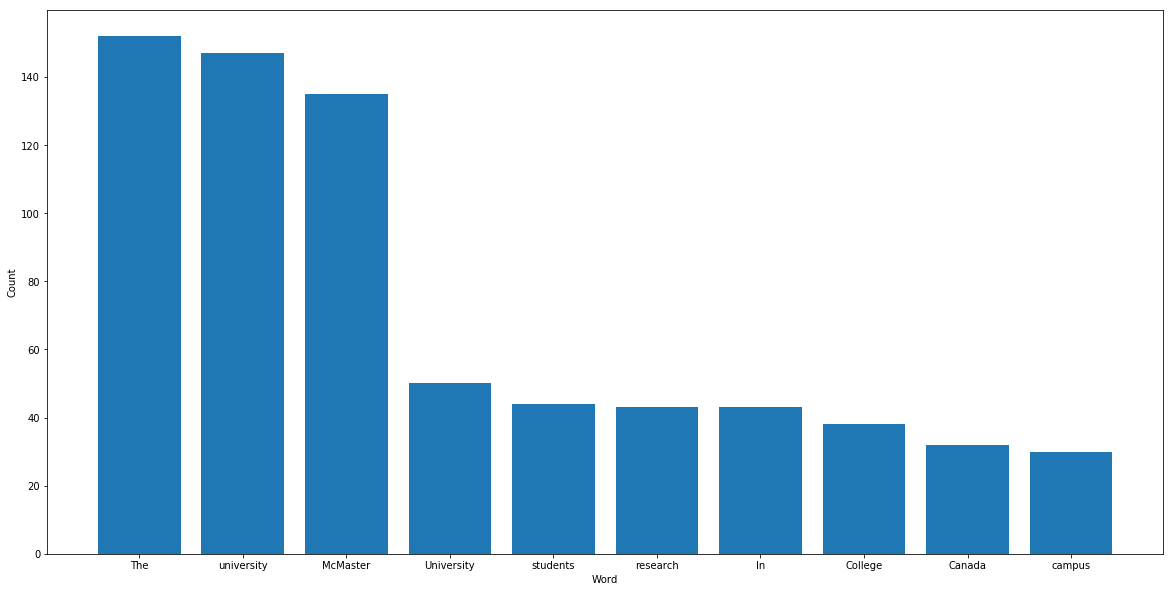

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.xlabel('Word')
plt.ylabel('Count')
plt.bar(largest_keys, largest_values)

plt.show()

That was the frequency, now let's calculate the weighted frequency
based on the maximum frequency

In [24]:
maximum_frequency = max(word_frequencies.values())
print(maximum_frequency)

for word in word_frequencies.keys():
    word_frequencies[word] = (word_frequencies[word]/maximum_frequency)

sentence_scores = {}
for sent in sentence_list:
    for word in nltk.word_tokenize(sent):
        if word in word_frequencies.keys():
            # Sentence with more than 20 words shouldn't be on the summary I guess
            if len(sent.split(' ')) < 20:
                if sent not in sentence_scores.keys():
                    sentence_scores[sent] = word_frequencies[word]
                else:
                    sentence_scores[sent] += word_frequencies[word]

152


Time to summarize

In [25]:
summary_sentences = heapq.nlargest(10, sentence_scores, key=sentence_scores.get)
summary = ' '.join(summary_sentences)
summary

"McMaster University (McMaster or Mac) is a public research university in Hamilton, Ontario, Canada. The university is home to two semi-professional acting companies, McMaster Musical Theatre and the McMaster Thespian Company. The university also awards degrees to graduate students of McMaster Divinity College. The historic Baptist connection was continued through McMaster Divinity College, a separately chartered affiliated college of the university. Thus, in 1957 the university reorganized once again under The McMaster University Act, 1957, dissolving the two colleges. Since 1968, the McMaster Engineering Society has published The Plumbline, the main satire magazine of McMaster University. McMaster's Faculty of Theology was spun-off into McMaster Divinity College, a separately-chartered affiliated college of the university. The university's present visual identity, and logo was approved by the university senate in 1997. In addition, the university also operates the McMaster Nuclear Re

Try to change the word count limit for a sentence to be in the summary and see if
the final summary would be different.